![](../images/FE_00.png)

# 1. Đọc dữ liệu

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from pyspark.sql import SparkSession

In [3]:
df = pd.read_excel("../data/womens-ecommerce-clothing-reviews/Womens_Clothing_E_Commerce_Reviews.xlsx", sheet_name="Reviews")

In [4]:
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [5]:
df = df.drop(columns=["Unnamed: 0"])

In [6]:
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [7]:
spark = SparkSession.builder.appName("Womens_Clothing_E_Commerce_Reviews").getOrCreate()

In [8]:
from modules.utils import createSparkDfFromXlsx

In [9]:
data = createSparkDfFromXlsx(df, spark)

In [10]:
type(data)

pyspark.sql.dataframe.DataFrame

# 2. Tiền xử lí dữ liệu
## 2.1. Tìm hiểu sơ bộ về dữ liệu

In [11]:
data.printSchema()

root
 |-- Clothing ID: long (nullable = true)
 |-- Age: long (nullable = true)
 |-- Title: double (nullable = true)
 |-- Review Text: string (nullable = true)
 |-- Rating: long (nullable = true)
 |-- Recommended IND: long (nullable = true)
 |-- Positive Feedback Count: long (nullable = true)
 |-- Division Name: string (nullable = true)
 |-- Department Name: string (nullable = true)
 |-- Class Name: string (nullable = true)



In [12]:
data.count()

23481

In [13]:
data.show(3)

+-----------+---+-----+--------------------+------+---------------+-----------------------+-------------+---------------+----------+
|Clothing ID|Age|Title|         Review Text|Rating|Recommended IND|Positive Feedback Count|Division Name|Department Name|Class Name|
+-----------+---+-----+--------------------+------+---------------+-----------------------+-------------+---------------+----------+
|        767| 33|  NaN|Absolutely wonder...|     4|              1|                      0|    Initmates|       Intimate| Intimates|
|       1080| 34|  NaN|Love this dress! ...|     5|              1|                      4|      General|        Dresses|   Dresses|
|       1077| 60| null|I had such high h...|     3|              0|                      0|      General|        Dresses|   Dresses|
+-----------+---+-----+--------------------+------+---------------+-----------------------+-------------+---------------+----------+
only showing top 3 rows



> **Nhận xét:**
> * Dữ liệu gồm $23,481$ mẫu.
> * Có chứa missing value.

In [14]:
data.select('Division Name').distinct().show()
data.select('Department Name').distinct().show()
data.select('Class Name').distinct().show()

+--------------+
| Division Name|
+--------------+
|     Initmates|
|       General|
|General Petite|
|           NaN|
+--------------+

+---------------+
|Department Name|
+---------------+
|        Dresses|
|           Tops|
|        Jackets|
|          Trend|
|       Intimate|
|        Bottoms|
|            NaN|
+---------------+

+--------------+
|    Class Name|
+--------------+
|       Dresses|
|     Outerwear|
|          Swim|
|       Blouses|
|         Knits|
|       Jackets|
|         Trend|
|        Lounge|
|      Chemises|
|         Pants|
|    Fine gauge|
|      Layering|
|        Skirts|
|     Intimates|
|Casual bottoms|
|       Legwear|
|           NaN|
|         Sleep|
|        Shorts|
|      Sweaters|
+--------------+
only showing top 20 rows



## 2.2. Lựa chọn thuộc tính

> **Nhận xét:**
> * Bài toán yêu câu xây dựng classification model để dự đoán `Rating` _(điểm đánh giá sản phẩm)_ của sản phẩm dựa trên các thuộc tính được cung cấp như sau:
>   * `Clothing ID`: ID sản phẩm _(số nguyên dương, category)_
>   * `Age`: tuổi của người viết đánh giá _(số nguyên dương)_
>   * `Review Text`: nội dung đánh giá _(chuổi)_
>   * `Recommended IND`: biến nhị phân cho biết khách hàng sẽ đề xuất sản phẩm này cho người khác hay ko, $1$ có và ngược lại
>   * `Positive Feedback Count`: số khách hàng khác cho rằng đánh giá của người này là tích cực _(số nguyên dương)_
>   * `Division Name`: phân bậc sản phẩm cấp 1, gồm bốn giá trị là `Initmates` (nội y), `General` (mọi người), `General Petite` (phụ nữ có tướng mình dây), `NaN`
>   * `Department Name`: phân bậc cấp 2 của sản phẩm
>   * `Class Name`: phân bậc cấp 3 của sản phẩm
> * Nhìn chung, ta thấy:
>   * Target variable: `Rating`
>   * Predictor variables: `Age`, `Review Text`, `Recommended IND`, `Positive Feedback Count`, `Class Name`

In [15]:
features = ['Age', 'Review Text', 'Recommended IND', 'Positive Feedback Count', 'Class Name']
target = 'Rating'

In [16]:
data_sub = data.select(features + [target])

In [17]:
data_sub.show(5)

+---+--------------------+---------------+-----------------------+----------+------+
|Age|         Review Text|Recommended IND|Positive Feedback Count|Class Name|Rating|
+---+--------------------+---------------+-----------------------+----------+------+
| 33|Absolutely wonder...|              1|                      0| Intimates|     4|
| 34|Love this dress! ...|              1|                      4|   Dresses|     5|
| 60|I had such high h...|              0|                      0|   Dresses|     3|
| 50|I love, love, lov...|              1|                      0|     Pants|     5|
| 47|This shirt is ver...|              1|                      6|   Blouses|     5|
+---+--------------------+---------------+-----------------------+----------+------+
only showing top 5 rows



In [18]:
data_sub.describe().toPandas()

,summary,Age,Review Text,Recommended IND,Positive Feedback Count,Class Name,Rating
0,count,23481,23481,23481,23481,23481,23481
1,mean,43.19837315276181,NaN,0.8224521953920191,2.5353690217622757,NaN,4.196286359184021
2,stddev,12.279291680205555,NaN,0.38213976604340594,5.702127864380743,NaN,1.1098198084654947
3,min,18,"""does this sweater make my hips look big?"" my ...",0,0,Blouses,1
4,max,99,"Yummy, soft material, but very faded looking. ...",1,122,Trend,5


> **Nhận xét:**
> * Dữ liệu ko có outlier
> * Thang đo giữa các thuộc tính đều nhau

## 2.3. Xem xét missing observation

In [19]:
from pyspark.sql.functions import *

In [20]:
tmp = data_sub.select([count(when((col(c) == '') | col(c).isNull() | isnan(c), c)).alias(c + " (% missing)") for c in data_sub.columns]).toPandas()
tmp = tmp / data_sub.count()

In [21]:
tmp

,Age (% missing),Review Text (% missing),Recommended IND (% missing),Positive Feedback Count (% missing),Class Name (% missing),Rating (% missing)
0,0.0,0.035987,0.0,0.0,0.000596,0.0


> **Nhận xét:**
> * Dữ liệu ta có $23481$ mẫu và missing value cùng lắm chỉ chiếm 3 phần trăm dữ liệu $\Rightarrow$ xóa các mẫu bị missing value.

In [22]:
data_sub = data_sub.filter(~col('Review Text').isNull() & ~(col('Review Text') == "") & ~(isnan('Review Text')))
data_sub = data_sub.filter(~col('Class Name').isNull() & ~(col('Class Name') == "") & ~(isnan('Class Name')))

In [23]:
data_sub.show(3)

+---+--------------------+---------------+-----------------------+----------+------+
|Age|         Review Text|Recommended IND|Positive Feedback Count|Class Name|Rating|
+---+--------------------+---------------+-----------------------+----------+------+
| 33|Absolutely wonder...|              1|                      0| Intimates|     4|
| 34|Love this dress! ...|              1|                      4|   Dresses|     5|
| 60|I had such high h...|              0|                      0|   Dresses|     3|
+---+--------------------+---------------+-----------------------+----------+------+
only showing top 3 rows



In [24]:
data_sub.count()

22623

> **Nhận xét**:
> * Sau khi loại bỏ các missing observation thì còn lại $22623$ sample.

## 2.4. Xóa các duplicated observation

In [25]:
1 - (data_sub.distinct().count() / data_sub.count())

0.00013260840737305823

> **Nhận xét**:
> * Có các duplicated observation $\Rightarrow$ xóa

In [26]:
data_sub = data_sub.dropDuplicates()

In [27]:
1 - (data_sub.distinct().count() / data_sub.count())

0.0

> **Nhận xét:**
> * OKLA

## 2.5. Xem xét các group trong target variable `Rating` đã đều nhau chưa

In [28]:
data_sub.groupBy('Rating').count().show()

+------+-----+
|Rating|count|
+------+-----+
|     5|12523|
|     1|  820|
|     3| 2822|
|     2| 1548|
|     4| 4907|
+------+-----+



In [29]:
import matplotlib.pyplot as plt
import pandas as pd

def barplot(pX: pd.Series, pY: pd.Series):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(pX, pY)
    ax.set_xlabel(pX.name)
    ax.set_ylabel(pY.name)

    plt.show()

In [30]:
tmp = data_sub.groupBy('Rating').count().toPandas()

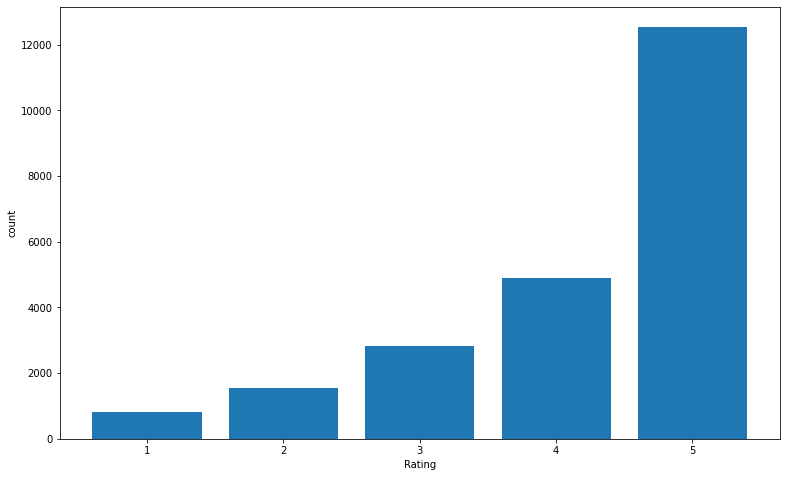

In [31]:
barplot(tmp['Rating'], tmp['count'])

> **Nhận xét**:
> * Các sample được đánh giá là $5$ sao vượt trội hơn so với các group còn lại, ta sẽ sampling nó lại sau các bước chuẩn dữ liệu

# 3. Chuẩn dữ liệu

In [32]:
data_sub.printSchema()

root
 |-- Age: long (nullable = true)
 |-- Review Text: string (nullable = true)
 |-- Recommended IND: long (nullable = true)
 |-- Positive Feedback Count: long (nullable = true)
 |-- Class Name: string (nullable = true)
 |-- Rating: long (nullable = true)



## 3.1. Chuyển đổi data type của các feature

In [33]:
from pyspark.sql.types import *

In [34]:
types_list = [IntegerType(), StringType(), IntegerType(), LongType(), StringType(), IntegerType()]

In [35]:
for i, c in enumerate(data_sub.columns):
    new_c = "".join(c.split(" "))
    data_sub = data_sub.withColumn(new_c, col(c).cast(types_list[i]))

In [36]:
data_sub.show(5)

+---+--------------------+---------------+-----------------------+----------+------+--------------------+--------------+---------------------+---------+
|Age|         Review Text|Recommended IND|Positive Feedback Count|Class Name|Rating|          ReviewText|RecommendedIND|PositiveFeedbackCount|ClassName|
+---+--------------------+---------------+-----------------------+----------+------+--------------------+--------------+---------------------+---------+
| 23|This shirt caught...|              1|                      3|   Blouses|     4|This shirt caught...|             1|                    3|  Blouses|
| 63|This dress first ...|              1|                      0|   Dresses|     5|This dress first ...|             1|                    0|  Dresses|
| 61|Nice fit and flar...|              1|                      1|   Dresses|     5|Nice fit and flar...|             1|                    1|  Dresses|
| 49|It was cute. i di...|              0|                      0|  Sweaters|     

In [37]:
data_sub = data_sub.drop('Review Text', 'Recommended IND', 'Positive Feedback Count', 'Class Name')

In [38]:
data_sub.show(5)

+---+------+--------------------+--------------+---------------------+---------+
|Age|Rating|          ReviewText|RecommendedIND|PositiveFeedbackCount|ClassName|
+---+------+--------------------+--------------+---------------------+---------+
| 23|     4|This shirt caught...|             1|                    3|  Blouses|
| 63|     5|This dress first ...|             1|                    0|  Dresses|
| 61|     5|Nice fit and flar...|             1|                    1|  Dresses|
| 49|     3|It was cute. i di...|             0|                    0| Sweaters|
| 37|     5|I tend to peruse ...|             1|                    0|    Knits|
+---+------+--------------------+--------------+---------------------+---------+
only showing top 5 rows



# 4. Chuyển dữ liệu

In [39]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer,VectorAssembler

In [40]:
reg_tokenizer = RegexTokenizer(inputCol='ReviewText', outputCol='ReviewText_tok', pattern="\\W")
stopremove = StopWordsRemover(inputCol='ReviewText_tok', outputCol='ReviewText_stp')
count_vec = CountVectorizer(inputCol='ReviewText_stp', outputCol='ReviewText_cvt')
idf = IDF(inputCol='ReviewText_cvt', outputCol='ReviewText_idf')
indexer = StringIndexer(inputCol='ClassName', outputCol='ClassName_idx')

In [41]:
from pyspark.ml import Pipeline

In [42]:
pipeline = Pipeline(stages=[indexer, reg_tokenizer, stopremove, count_vec, idf])

In [43]:
clean_data = pipeline.fit(data_sub).transform(data_sub)

In [44]:
clean_data.show(5)

+---+------+--------------------+--------------+---------------------+---------+-------------+--------------------+--------------------+--------------------+--------------------+
|Age|Rating|          ReviewText|RecommendedIND|PositiveFeedbackCount|ClassName|ClassName_idx|      ReviewText_tok|      ReviewText_stp|      ReviewText_cvt|      ReviewText_idf|
+---+------+--------------------+--------------+---------------------+---------+-------------+--------------------+--------------------+--------------------+--------------------+
| 23|     4|This shirt caught...|             1|                    3|  Blouses|          2.0|[this, shirt, cau...|[shirt, caught, e...|(14158,[1,6,8,12,...|(14158,[1,6,8,12,...|
| 63|     5|This dress first ...|             1|                    0|  Dresses|          0.0|[this, dress, fir...|[dress, first, ca...|(14158,[0,4,6,11,...|(14158,[0,4,6,11,...|
| 61|     5|Nice fit and flar...|             1|                    1|  Dresses|          0.0|[nice, fit,

# 5. Ghi ra file `*.csv`

In [45]:
clean_data.write.parquet("../data/womens-ecommerce-clothing-reviews/womens-ecommerce-clothing-reviews_clean_data.parquet")